In [ ]:
import tensorflow as tf
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
import cv2
import random
import keras.backend as K
import sklearn
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROOT_DIR = '/content/drive/MyDrive/Broner'
train_data = pd.read_csv('/content/drive/MyDrive/Broner/MURA-v1.1/train_path_label.csv' , dtype=str)
test_data  = pd.read_csv('/content/drive/MyDrive/Broner/MURA-v1.1/valid_path_label.csv' , dtype=str)
train_data


,0,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,0
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,0


In [ ]:
train_shoulder = train_data[:1300]
train_humerus  = train_data[8379:9651]
train_forearm  = train_data[29940:31265]
 
test_shoulder = test_data[1708:2100]
test_forearm  = test_data[659:960]
test_humerus  = test_data[1420:1708]

In [ ]:
def change_class(df,val):
  for i in range(len(df)):
    df['label'] = val
  return df
temp = change_class(train_shoulder,'0')
type(temp['label'][0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


str

In [ ]:
train_shoulder = change_class(train_shoulder,'0')
train_humerus = change_class(train_humerus,'1')
train_forearm = change_class(train_forearm,'2')

test_shoulder = change_class(test_shoulder,'0')
test_humerus = change_class(test_humerus,'1')
test_forearm = change_class(test_forearm,'2')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train_data = pd.concat([train_shoulder , train_forearm , train_humerus] , ignore_index=True)
train_data

,0,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,0
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,0
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,0
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,0
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,0
...,...,...
3892,MURA-v1.1/train/XR_HUMERUS/patient03224/study1...,1
3893,MURA-v1.1/train/XR_HUMERUS/patient03225/study1...,1
3894,MURA-v1.1/train/XR_HUMERUS/patient03225/study1...,1
3895,MURA-v1.1/train/XR_HUMERUS/patient03226/study1...,1


In [ ]:
test_data = pd.concat([test_shoulder , test_forearm , test_humerus] , ignore_index=True)
test_data

,0,label
0,MURA-v1.1/valid/XR_SHOULDER/patient11676/study...,0
1,MURA-v1.1/valid/XR_SHOULDER/patient11676/study...,0
2,MURA-v1.1/valid/XR_SHOULDER/patient11676/study...,0
3,MURA-v1.1/valid/XR_SHOULDER/patient11703/study...,0
4,MURA-v1.1/valid/XR_SHOULDER/patient11703/study...,0
...,...,...
976,MURA-v1.1/valid/XR_HUMERUS/patient11225/study1...,1
977,MURA-v1.1/valid/XR_HUMERUS/patient11701/study1...,1
978,MURA-v1.1/valid/XR_HUMERUS/patient11701/study1...,1
979,MURA-v1.1/valid/XR_HUMERUS/patient11702/study1...,1


In [ ]:
train_data = train_data.sample(frac = 1)
test_data  = test_data.sample(frac = 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train , x_val , y_train , y_val = train_test_split(train_data['0'] , train_data['label'] , test_size = 0.2 , random_state=42 , stratify=train_data['label'])

In [ ]:
val_data = pd.DataFrame()
val_data['0']=x_val
val_data['label']=y_val
val_data.reset_index(inplace=True,drop=True)
val_data

,0,label
0,MURA-v1.1/train/XR_HUMERUS/patient02892/study1...,1
1,MURA-v1.1/train/XR_FOREARM/patient09420/study1...,2
2,MURA-v1.1/train/XR_HUMERUS/patient02419/study1...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00006/study...,0
4,MURA-v1.1/train/XR_HUMERUS/patient03009/study1...,1
...,...,...
775,MURA-v1.1/train/XR_SHOULDER/patient00101/study...,0
776,MURA-v1.1/train/XR_HUMERUS/patient03095/study1...,1
777,MURA-v1.1/train/XR_FOREARM/patient09251/study1...,2
778,MURA-v1.1/train/XR_SHOULDER/patient00022/study...,0


In [ ]:
print(len(train_data) , len(test_data) , len(val_data))

3897 981 780


In [ ]:
def preproc(image):
  image = image/255.
  image[:,:,0] = (image[:,:,0]-0.485)/0.229
  image[:,:,1] = (image[:,:,1]-0.456)/0.224
  image[:,:,2] = (image[:,:,2]-0.406)/0.225
  return image

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preproc,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range = 0.15,
    validation_split = 0.1)

test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preproc) 

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train_data,
directory=ROOT_DIR, 
x_col="0",
y_col="label",
subset="training",
batch_size=128,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(320,320))
 
valid_generator=train_datagen.flow_from_dataframe(
dataframe=train_data,
directory=ROOT_DIR,
x_col="0",
y_col="label",
subset="validation",
batch_size=128,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(320,320))

Found 3508 validated image filenames belonging to 3 classes.
Found 389 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation, Convolution2D, MaxPooling2D

In [ ]:
# TARGET_SIZE = 320
# cnn = Sequential()
# cnn.add(Convolution2D(filters=32, kernel_size=5, padding ="same", input_shape=(TARGET_SIZE, TARGET_SIZE, 3), activation='relu'))
# cnn.add(MaxPooling2D(pool_size=(3,3)))

# cnn.add(Convolution2D(filters=64, kernel_size=3, padding ="same",activation='relu'))
# cnn.add(MaxPooling2D(pool_size=(3,3)))

# cnn.add(Convolution2D(filters=128, kernel_size=3, padding ="same",activation='relu'))
# cnn.add(MaxPooling2D(pool_size=(3,3)))

# cnn.add(Flatten())
# cnn.add(Dense(100, activation='relu'))
# cnn.add(Dropout(0.5))
# cnn.add(Dense(3, activation='softmax'))
# cnn.summary()
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
def make_model(metrics = None):    
        
    base_model = keras.applications.InceptionResNetV2(input_shape=(*[320,320], 3),
                                                include_top=False,
                                                weights='imagenet')
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(512),
        BatchNormalization(),
        keras.layers.Activation('relu'),
        Dropout(0.5),
        keras.layers.Dense(256),
        BatchNormalization(),
        keras.layers.Activation('relu'),
        Dropout(0.4),
        keras.layers.Dense(128),
        BatchNormalization(),
        keras.layers.Activation('relu'),
        Dropout(0.3),
        keras.layers.Dense(64),
        BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=metrics)
    
    return model

In [ ]:
# def exponential_decay(lr0):
#     def exponential_decay_fn(epoch):
#       if epoch>5 and epoch%3==0:
#         return lr0 * tf.math.exp(-0.1)
#       else:
#         return lr0
#     return exponential_decay_fn

# exponential_decay_fn = exponential_decay(0.01)
# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Broner/bone.h5",
#                                                     save_best_only=True)
checkpoint_path = "/content/drive/MyDrive/Broner/best.hdf5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_sparse_categorical_accuracy',
                                                 save_best_only=True, 
                                                 save_weights_only=True,
                                                 mode='max', 
                                                 verbose=1)

In [ ]:
model = make_model(metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               786944    
_________________________________________________________________
batch_normalization_410 (Bat (None, 512)               2048      
_________________________________________________________________
activation_410 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [ ]:
# cnn = model

In [ ]:
LR = 0.0005
EPOCHS=20

STEPS=train_generator.n//train_generator.batch_size
VALID_STEPS=valid_generator.n//valid_generator.batch_size
# cnn.compile(
#   optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
#   loss='sparse_categorical_crossentropy',
#   metrics=['sparse_categorical_accuracy'])

In [ ]:
# checkpoint_path = "/content/drive/MyDrive/Broner/best.hdf5"
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  monitor='val_sparse_categorical_accuracy',
#                                                  save_best_only=True, 
#                                                  save_weights_only=True,
#                                                  mode='max', 
#                                                  verbose=1)

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEPS,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[cp_callback],
    validation_steps=VALID_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
27/27 [==============================] - 1053s 38s/step - loss: 1.0587 - sparse_categorical_accuracy: 0.5071 - val_loss: 0.6521 - val_sparse_categorical_accuracy: 0.7839

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.78385, saving model to /content/drive/MyDrive/Broner/best.hdf5
Epoch 2/20
27/27 [==============================] - 106s 4s/step - loss: 0.5640 - sparse_categorical_accuracy: 0.7785 - val_loss: 0.4373 - val_sparse_categorical_accuracy: 0.8802

Epoch 00002: val_sparse_categorical_accuracy improved from 0.78385 to 0.88021, saving model to /content/drive/MyDrive/Broner/best.hdf5
Epoch 3/20
27/27 [==============================] - 106s 4s/step - loss: 0.4174 - sparse_categorical_accuracy: 0.8488 - val_loss: 0.4011 - val_sparse_categorical_accuracy: 0.8672

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.88021
Epoch 4/20
27/27 [==============================] - 107s 4s/step - loss: 0.3353 - sparse_categorical_accuracy: 0.8680

In [ ]:
model.save('/content/drive/MyDrive/Broner/model.h5')

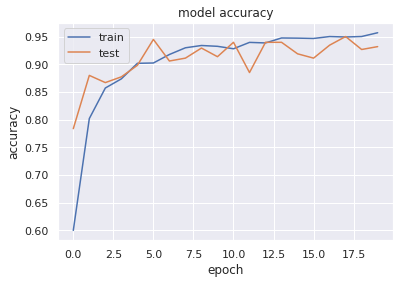

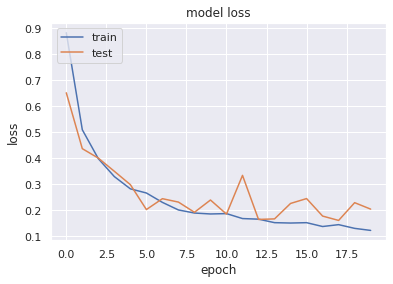

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
import h5py
from keras.preprocessing import image    
m = load_model('/content/drive/MyDrive/Broner/model.h5')

In [ ]:
def new_answer(img):
  arr = np.empty(5, dtype=int)
  # img = image.load_img(path,target_size=(320,320))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor,axis = 0)
  img_tensor /= 255
  img_tensor[:,:,0] = (img_tensor[:,:,0]-0.485)/0.229
  img_tensor[:,:,1] = (img_tensor[:,:,1]-0.456)/0.224
  img_tensor[:,:,2] = (img_tensor[:,:,2]-0.406)/0.225
  ans = m.predict(img_tensor)
  return np.argmax(ans),ans

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Broner/MURA-v1.1/valid/XR_SHOULDER/patient11187/study1_negative/image1.png')
resized = cv2.resize(img, (320,320))
new_answer(resized)
#Shoulder = '0' Humerus = '1'  Forearm = '2'

(0, array([[0.64501244, 0.3328251 , 0.02216248]], dtype=float32))

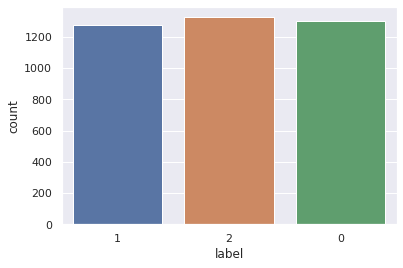

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train_data)